<a href="https://colab.research.google.com/github/roboy88/Big-Tech-Stock-Data-Analysis/blob/main/AIStocktrackerapp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
def fetch_history(symbol, period="6mo"):
    df = yf.download(symbol, period=period, progress=False)
    if df is None or df.empty:
        return pd.DataFrame() # Return an empty DataFrame if no data is found
    return df

In [3]:
import asyncio, time, json, math
import numpy as np
import pandas as pd
import yfinance as yf
import nest_asyncio
from fastapi import FastAPI, WebSocket, WebSocketDisconnect
from pydantic import BaseModel
import requests # Import the requests library
import threading # Import threading

nest_asyncio.apply()

# ============================================================
# UNIVERSES
# ============================================================

def get_sp500_tickers():
    url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
    # Add a User-Agent header to mimic a web browser
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
    }
    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()  # Raise an HTTPError for bad responses (4xx or 5xx)
        df = pd.read_html(response.text)[0]
        return df["Symbol"].astype(str).str.replace(".", "-", regex=False).tolist()
    except requests.exceptions.RequestException as e:
        print(f"Error fetching S&P 500 tickers: {e}")
        return [] # Return an empty list if there's an error

SP500 = get_sp500_tickers()

TOP_MARKETS = {
    "NASDAQ_100": "QQQ",
    "DOW_JONES": "DIA",
    "FTSE_100_UK": "EWU",
    "DAX_GERMANY": "EWG",
    "CAC_FRANCE": "EWQ",
    "NIKKEI_JAPAN": "EWJ",
    "HANG_SENG": "EWH",
    "CHINA_MAINLAND": "MCHI",
    "CANADA_TSX": "EWC",
    "AUSTRALIA_ASX": "EWA",
}

# ============================================================
# MARKET DATA
# ============================================================

def fetch_quote(symbol):
    try:
        fi = yf.Ticker(symbol).fast_info
        return {
            "symbol": symbol,
            "last": fi.get("last_price"),
            "prev_close": fi.get("previous_close"),
            "volume": fi.get("last_volume"),
            "market_cap": fi.get("market_cap"),
            "exchange": fi.get("exchange"),
            "timestamp": int(time.time())
        }
    except Exception as e:
        return {"symbol": symbol, "error": str(e)}

def fetch_history(symbol, period="6mo"):
    df = yf.download(symbol, period=period, progress=False)
    if df is None or df.empty:
        return None
    df = df.reset_index()
    df.columns = [c.lower() for c in df.columns]
    return df

# ============================================================
# FEATURES
# ============================================================

def compute_features(df):
    close = df["close"].values
    if len(close) < 30:
        return {"error": "insufficient history"}

    returns = np.diff(np.log(close))
    peak = np.maximum.accumulate(close)
    drawdown = (close / peak) - 1

    return {
        "momentum_20d": float(close[-1] / close[-21] - 1),
        "momentum_60d": float(close[-1] / close[-61] - 1) if len(close) >= 61 else None,
        "volatility": float(np.std(returns[-20:]) * np.sqrt(252)),
        "max_drawdown": float(drawdown.min())
    }

# ============================================================
# AGENTS
# ============================================================

class AgentOutput(BaseModel):
    agent: str
    claims: list
    risks: list
    score: float
    confidence: float

def clamp(x): return max(-1, min(1, x))

def market_agent(ctx):
    q = ctx["quote"]
    claims, risks, score = [], [], 0
    if q.get("last") and q.get("prev_close"):
        chg = q["last"] / q["prev_close"] - 1
        claims.append(f"Price change: {chg:.2%}")
        score += chg * 5
    else:
        risks.append("Missing live price")
    return AgentOutput(agent="Market", claims=claims, risks=risks, score=clamp(score), confidence=0.6)

def technical_agent(ctx):
    f = ctx["features"]
    claims, risks, score = [], [], 0
    if "error" in f:
        risks.append("Insufficient technical history")
        return AgentOutput(agent="Technicals", claims=claims, risks=risks, score=0, confidence=0.3)

    claims.append(f"20D momentum: {f['momentum_20d']:.2%}")
    score += f["momentum_20d"] * 4

    if f["volatility"] > 0.45:
        risks.append("High volatility regime")
        score -= 0.2

    return AgentOutput(agent="Technicals", claims=claims, risks=risks, score=clamp(score), confidence=0.6)

def fundamentals_agent(ctx):
    t = ctx["ticker"]
    claims, risks, score = [], [], 0
    try:
        pe = t.info.get("trailingPE")
        if pe:
            claims.append(f"P/E: {pe:.1f}")
            score += 0.2 if pe < 20 else -0.2
    except:
        risks.append("Fundamentals unavailable")
    return AgentOutput(agent="Fundamentals", claims=claims, risks=risks, score=clamp(score), confidence=0.5)

def risk_agent(ctx):
    f = ctx["features"]
    risks, score = [], 0
    if f.get("max_drawdown", 0) < -0.3:
        risks.append("Severe drawdown risk")
        score -= 0.3
    return AgentOutput(agent="Risk", claims=[], risks=risks, score=clamp(score), confidence=0.7)

def skeptic_agent(ctx):
    return AgentOutput(
        agent="Skeptic",
        claims=["Momentum can mean-revert", "Data ≠ destiny"],
        risks=["Overconfidence bias"],
        score=-0.1,
        confidence=0.8
    )

# ============================================================
# CHAIR
# ============================================================

def chair(outputs):
    weighted, wsum = 0, 0
    claims, risks = [], []

    for o in outputs:
        w = o.confidence
        weighted += o.score * w
        wsum += w
        claims += [f"[{o.agent}] {c}" for c in o.claims]
        risks += [f"[{o.agent}] {r}" for r in o.risks]

    score = weighted / wsum if wsum else 0
    rating = "BULLISH" if score > 0.25 else "BEARISH" if score < -0.25 else "NEUTRAL"

    return {
        "rating": rating,
        "ensemble_score": round(score, 3),
        "claims": claims[:10],
        "risks": risks[:10],
        "assumptions": ["Data is current", "Signals are descriptive"],
        "disconfirming_signals": ["Earnings shock", "Liquidity event"]
    }

# ============================================================
# PIPELINE
# ============================================================

def run_research(symbol):
    t = yf.Ticker(symbol)
    q = fetch_quote(symbol)
    h = fetch_history(symbol)
    f = compute_features(h) if h is not None else {"error": "no history"}

    ctx = {"symbol": symbol, "ticker": t, "quote": q, "features": f}

    outputs = [
        market_agent(ctx),
        technical_agent(ctx),
        fundamentals_agent(ctx),
        risk_agent(ctx),
        skeptic_agent(ctx)
    ]

    result = chair(outputs)
    result["agent_outputs"] = [o.dict() for o in outputs]
    return result

# ============================================================
# FASTAPI APP
# ============================================================

app = FastAPI(title="Multi-Agent Stock Research Demo")

class ResearchRequest(BaseModel):
    symbol: str

@app.get("/universes")
def universes():
    return {
        "sp500_count": len(SP500),
        "top_markets": TOP_MARKETS
    }

@app.post("/research")
def research(req: ResearchRequest):
    return run_research(req.symbol.upper())

@app.websocket("/ws/research/{symbol}")
async def ws_research(ws: WebSocket, symbol: str):
    await ws.accept()
    try:
        for stage in ["quote", "features", "agents", "decision"]:
            await ws.send_json({"stage": stage})
            await asyncio.sleep(0.4)
        await ws.send_json({"result": run_research(symbol.upper())})
    except WebSocketDisconnect:
        pass

# ============================================================
# LAUNCH (ngrok)
# ============================================================

# REMEMBER TO REPLACE "YOUR_AUTHTOKEN" WITH YOUR ACTUAL NGROK AUTH TOKEN
# ngrok.set_auth_token("YOUR_AUTHTOKEN") # Commented out as per user request
# public_url = ngrok.connect(8000) # Commented out as per user request
# print("PUBLIC URL:", public_url) # Commented out as per user request
print("ngrok functionality disabled. FastAPI app will run locally.") # Added message

import uvicorn

# Function to run the FastAPI app
def run_fastapi():
    uvicorn.run(app, host="0.0.0.0", port=8000)

# Run FastAPI in a separate thread to avoid asyncio conflicts in Colab
thread = threading.Thread(target=run_fastapi)
thread.start()

# You might want to add a loop here to keep the Colab cell alive if needed
# For example:
# try:
#     while True:
#         time.sleep(1)
# except KeyboardInterrupt:
#     print("Server stopped.")
#     thread.join()

/tmp/ipython-input-3879213201.py:26: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(response.text)[0]


ngrok functionality disabled. FastAPI app will run locally.


Tickers loaded: 80
Processed 10/80 symbols...
Processed 20/80 symbols...
Processed 30/80 symbols...
Processed 40/80 symbols...
Processed 50/80 symbols...
Processed 60/80 symbols...
Processed 70/80 symbols...
Processed 80/80 symbols...
Panel shape: (53840, 13)
        date    mom_5d   mom_20d   mom_60d   vol_20d  trend_20  trend_60  \
0 2023-04-27 -0.016823 -0.004483 -0.123816  0.296226 -0.030123 -0.054809   
1 2023-04-27  0.010561  0.047521  0.167163  0.202367  0.022697  0.075097   
2 2023-04-27 -0.079572 -0.057785  0.007580  0.310020 -0.073881 -0.040019   
3 2023-04-27 -0.026605 -0.029882  0.037260  0.360422 -0.009205 -0.036297   
4 2023-04-27 -0.007703  0.110322 -0.009498  0.315957  0.036647  0.055914   

   drawdown  dollar_vol_20d  hl_range   fwd_ret  label_up symbol  
0 -0.143087    2.040095e+08  0.018987 -0.103265         0      A  
1  0.000000    8.507962e+09  0.020011  0.027196         1   AAPL  
2 -0.097210    8.066304e+08  0.045073 -0.068852         0   ABBV  
3 -0.173361    

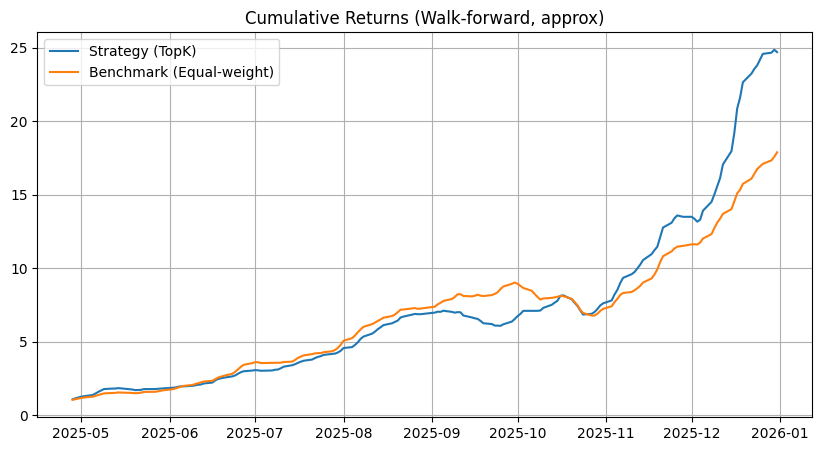

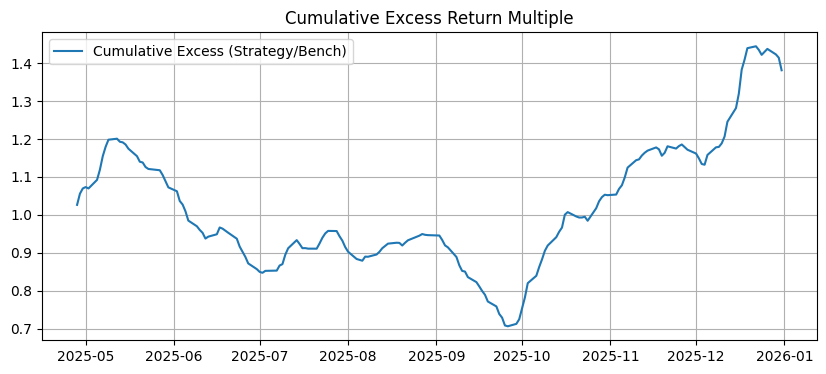


Feature Importances (last window):
          feature  importance
7  dollar_vol_20d    0.210457
6        drawdown    0.183680
2         mom_60d    0.156713
3         vol_20d    0.154799
1         mom_20d    0.094476
5        trend_60    0.083354
4        trend_20    0.046852
0          mom_5d    0.037559
8        hl_range    0.032110


In [11]:
# ============================================================
# DATA SCIENCE PROJECT: S&P 500 Cross-Sectional Return Prediction
# - Uses your fetch_history() concept (yfinance)
# - Builds a panel dataset: (date, symbol) -> features, label
# - Walk-forward training and backtest
# ============================================================

!pip -q install yfinance pandas numpy scikit-learn lxml requests matplotlib

import warnings, time, math
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import yfinance as yf
import requests
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# -----------------------------
# 1) Your function (kept simple & safe)
# -----------------------------
def fetch_history(symbol, period="6mo"):
    df = yf.download(symbol, period=period, progress=False, auto_adjust=False)
    if df is None or df.empty:
        return pd.DataFrame()  # Return an empty DataFrame if no data is found

    # Reset index first to turn 'Date' index into a column named 'Date' (or 'index' if no name)
    df = df.reset_index()

    # Handle potential MultiIndex columns (less common after reset_index, but good for robustness)
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)

    # Then, lowercase and clean up all column names, including the new 'date' column
    df.columns = [col.lower().replace(" ", "_").replace(".", "") for col in df.columns]
    return df

# -----------------------------
# 2) Universe: S&P 500 tickers
# -----------------------------
def get_sp500_tickers():
    url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
    headers = {"User-Agent": "Mozilla/5.0"}
    html = requests.get(url, headers=headers, timeout=20).text
    df = pd.read_html(html)[0]
    return df["Symbol"].astype(str).str.replace(".", "-", regex=False).tolist()

SP500 = get_sp500_tickers()

# For Colab speed, start with a subset. Increase N for more coverage.
N = 80  # <- bump to 200 or 500 if you enjoy waiting and rate limits
tickers = SP500[:N]

print("Tickers loaded:", len(tickers))

# -----------------------------
# 3) Feature engineering on one symbol
# -----------------------------
def compute_features_one(df):
    """
    Input: yfinance OHLCV df with columns: Open High Low Close Adj Close Volume
    Output: DataFrame indexed by date with engineered features
    """
    if df.empty:
        return pd.DataFrame()

    df = df.copy()

    # Column names are already lowercased by fetch_history, including 'date'
    df.index = pd.to_datetime(df["date"])

    if 'close' not in df.columns:
        print(f"WARNING: 'close' column not found after renaming for a symbol. Columns: {df.columns.tolist()}")
        return pd.DataFrame() # Return empty DataFrame if 'close' is missing

    # Basic returns
    df["ret_1d"] = df["close"].pct_change()

    # Momentum
    df["mom_5d"]  = df["close"].pct_change(5)
    df["mom_20d"] = df["close"].pct_change(20)
    df["mom_60d"] = df["close"].pct_change(60)

    # Volatility (annualized-ish)
    df["vol_20d"] = df["ret_1d"].rolling(20).std() * np.sqrt(252)

    # Trend strength: distance from moving averages
    df["ma_20"] = df["close"].rolling(20).mean()
    df["ma_60"] = df["close"].rolling(60).mean()
    df["trend_20"] = (df["close"] / df["ma_20"]) - 1
    df["trend_60"] = (df["close"] / df["ma_60"]) - 1

    # Drawdown
    roll_max = df["close"].cummax()
    df["drawdown"] = (df["close"] / roll_max) - 1

    # Liquidity-ish proxies (not perfect, but useful)
    df["dollar_vol"] = df["close"] * df["volume"]
    df["dollar_vol_20d"] = df["dollar_vol"].rolling(20).mean()

    # Simple range / “intraday volatility” proxy
    df["hl_range"] = (df["high"] - df["low"]) / df["close"]

    # Clean up
    feats = df[[
        "mom_5d","mom_20d","mom_60d",
        "vol_20d","trend_20","trend_60",
        "drawdown","dollar_vol_20d","hl_range"
    ]].dropna()

    return feats

# -----------------------------
# 4) Labeling: forward return and classification label
# -----------------------------
def make_labels(price_df, horizon=20):
    """
    horizon: forward return window in trading days
    label: 1 if forward return > 0 else 0
    """
    if price_df.empty:
        return pd.DataFrame()

    # Assume 'date' column is present and set as index for time series ops
    df_temp = price_df.copy()
    df_temp.index = pd.to_datetime(df_temp["date"])

    if 'close' not in df_temp.columns:
        print(f"WARNING: 'close' column not found in DataFrame for make_labels. Columns: {df_temp.columns.tolist()}")
        return pd.DataFrame()

    px = df_temp["close"].copy() # 'close' column is now consistently lowercased
    fwd_ret = px.shift(-horizon) / px - 1
    out = pd.DataFrame({
        "fwd_ret": fwd_ret,
        "label_up": (fwd_ret > 0).astype(int)
    }, index=px.index) # Preserve the date index
    return out

# -----------------------------
# 5) Build panel dataset (date, symbol)
# -----------------------------
def build_panel(tickers, period="3y", horizon=20, max_symbols=None, sleep_sec=0.0):
    rows = []
    for i, sym in enumerate(tickers[:max_symbols] if max_symbols else tickers, start=1):
        df = fetch_history(sym, period=period)
        if df.empty:
            continue

        feats = compute_features_one(df)
        labels = make_labels(df, horizon=horizon) # make_labels should operate on the original df, not feats

        # Align
        merged = feats.join(labels, how="inner").dropna()
        if merged.empty:
            continue

        merged["symbol"] = sym
        merged = merged.reset_index().rename(columns={"index":"date"})
        rows.append(merged)

        if sleep_sec:
            time.sleep(sleep_sec)

        if i % 10 == 0:
            print(f"Processed {i}/{len(tickers)} symbols...")

    panel = pd.concat(rows, ignore_index=True) if rows else pd.DataFrame()
    panel = panel.sort_values(["date","symbol"]).reset_index(drop=True)
    return panel

panel = build_panel(tickers, period="3y", horizon=20, sleep_sec=0.0)
print("Panel shape:", panel.shape)
print(panel.head())

# -----------------------------
# 6) Train/test split (walk-forward by date)
# -----------------------------
FEATURES = ["mom_5d","mom_20d","mom_60d","vol_20d","trend_20","trend_60","drawdown","dollar_vol_20d","hl_range"]

panel["date"] = pd.to_datetime(panel["date"])
dates = sorted(panel["date"].unique())

# Walk-forward settings
train_years = 2
test_months = 3

def date_add_months(dt, months):
    # crude month add, good enough for splitting windows
    return (pd.Timestamp(dt) + pd.DateOffset(months=months)).normalize()

start_date = dates[0]
end_date = dates[-1]

# Define rolling windows based on calendar time
windows = []
cur_train_end = date_add_months(start_date, train_years * 12)

while cur_train_end < end_date:
    cur_test_end = date_add_months(cur_train_end, test_months)
    windows.append((start_date, cur_train_end, cur_train_end, cur_test_end))
    # roll forward by test period
    cur_train_end = cur_test_end

print("Walk-forward windows:", len(windows))
print("First window:", windows[0])

# -----------------------------
# 7) Model + evaluation + backtest
# -----------------------------
# Pipeline: scaling + RandomForest (works without tons of tuning)
model = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("rf", RandomForestClassifier(
        n_estimators=250,
        max_depth=6,
        min_samples_leaf=50,
        random_state=42,
        n_jobs=-1
    ))
])

def backtest_topk(panel_slice, proba_col="p_up", topk=20):
    """
    Long-only: equal weight top K by predicted probability.
    Returns average next-horizon forward return for the chosen names, per date.
    """
    out = []
    for d, g in panel_slice.groupby("date"):
        g = g.sort_values(proba_col, ascending=False).head(topk)
        out.append({"date": d, "strategy_ret": g["fwd_ret"].mean()})
    return pd.DataFrame(out).sort_values("date")

def benchmark_equal_weight(panel_slice):
    """
    Equal-weight benchmark: average forward return across all names per date.
    """
    out = panel_slice.groupby("date")["fwd_ret"].mean().reset_index()
    out = out.rename(columns={"fwd_ret":"bench_ret"})
    return out.sort_values("date")

metrics = []
all_bt = []

for (train_start, train_end, test_start, test_end) in windows:
    train = panel[(panel["date"] >= train_start) & (panel["date"] < train_end)].copy()
    test  = panel[(panel["date"] >= test_start)  & (panel["date"] < test_end)].copy()

    if len(train) < 1000 or len(test) < 200:
        continue

    X_train, y_train = train[FEATURES], train["label_up"]
    X_test,  y_test  = test[FEATURES],  test["label_up"]

    model.fit(X_train, y_train)
    p = model.predict_proba(X_test)[:,1]

    test["p_up"] = p

    # Classification metrics
    auc = roc_auc_score(y_test, p)
    pred = (p > 0.5).astype(int)
    acc = accuracy_score(y_test, pred)

    # Information coefficient (rank correlation proxy)
    ic = test[["p_up","fwd_ret"]].corr(method="spearman").iloc[0,1]

    # Backtest: top K
    bt = backtest_topk(test, proba_col="p_up", topk=20)
    bench = benchmark_equal_weight(test)
    bt = bt.merge(bench, on="date", how="inner")
    bt["excess_ret"] = bt["strategy_ret"] - bt["bench_ret"]
    bt["window_train_end"] = train_end
    bt["window_test_end"] = test_end

    metrics.append({
        "train_end": train_end,
        "test_end": test_end,
        "auc": auc,
        "acc": acc,
        "ic_spearman": ic,
        "mean_strategy_ret": bt["strategy_ret"].mean(),
        "mean_bench_ret": bt["bench_ret"].mean(),
        "mean_excess_ret": bt["excess_ret"].mean(),
    })

    all_bt.append(bt)

results = pd.DataFrame(metrics)
bt_all = pd.concat(all_bt, ignore_index=True) if all_bt else pd.DataFrame()

print("\n=== Walk-forward summary ===")
print(results.describe(include="all"))

# -----------------------------
# 8) Plot cumulative performance (approx)
# -----------------------------
if not bt_all.empty:
    # Convert forward returns to "equity curve" style compounding
    bt_all = bt_all.sort_values("date").copy()
    bt_all["cum_strategy"] = (1 + bt_all["strategy_ret"].fillna(0)).cumprod()
    bt_all["cum_bench"] = (1 + bt_all["bench_ret"].fillna(0)).cumprod()
    bt_all["cum_excess"] = bt_all["cum_strategy"] / bt_all["cum_bench"]

    plt.figure(figsize=(10,5))
    plt.plot(bt_all["date"], bt_all["cum_strategy"], label="Strategy (TopK)")
    plt.plot(bt_all["date"], bt_all["cum_bench"], label="Benchmark (Equal-weight)")
    plt.title("Cumulative Returns (Walk-forward, approx)")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10,4))
    plt.plot(bt_all["date"], bt_all["cum_excess"], label="Cumulative Excess (Strategy/Bench)")
    plt.title("Cumulative Excess Return Multiple")
    plt.legend()
    plt.grid(True)
    plt.show()

# -----------------------------
# 9) Feature importance (rough, from last trained model)
# -----------------------------
try:
    rf = model.named_steps["rf"]
    importances = rf.feature_importances_
    fi = pd.DataFrame({"feature": FEATURES, "importance": importances}).sort_values("importance", ascending=False)
    print("\nFeature Importances (last window):")
    print(fi)
except Exception as e:
    print("Feature importance unavailable:", e)

# -----------------------------
# 10) Export dataset (optional)
# -----------------------------
# panel.to_csv("sp500_panel_dataset.csv", index=False)
# print("Saved: sp500_panel_dataset.csv")

[link text](https://)https://github.com/roboy88/cryptocurrencies-/blob/main/Resources/crypto_data.csv